#DCGAN

Based in the proposed paper : https://arxiv.org/abs/1511.06434

##Install Libraries

In [1]:
!pip install pytorch-msssim
!pip install faiss-cpu

## Import libraries

In [2]:
import torch
import torch.nn.functional as F
from torchvision import models
from pytorch_msssim import ssim  # For SSIM metric
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torchsummary import summary
import torch.optim as optim
import logging

In [3]:
# Define device as cuda if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
 # Define transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
# Dataset

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

In [6]:
# number of channels
nc=1

# input noise dimension
nz = 100

# number of generator filters
ngf = 64

#number of discriminator filters
ndf = 64

## Discriminator definition

In [7]:
# Baseline from LAB 5(INM705 Deep Learning for Image Analysis)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.model = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Conv2d(self.ndf,self.ndf*2, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear((self.ndf*2)*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Generator definition

In [8]:
# Baseline from LAB 5 (INM705 Deep Learning for Image Analysis)

class Generator(nn.Module):
      def __init__(self, nc, ngf, nz):
        super(Generator, self).__init__()
        self.nc = nc
        self.ngf = ngf
        self.nz = nz
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*(self.ngf*4), bias=False),
            nn.BatchNorm1d(7*7*(self.ngf*4)),
            nn.LeakyReLU(0.3),
            nn.Unflatten(self.nc, (self.ngf*4, 7, 7)),
            nn.ConvTranspose2d(self.ngf*4, self.ngf*2, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(self.ngf*2),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(self.ngf*2, self.ngf, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(self.ngf, self.nc, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

      def forward(self, x):
        return self.model(x)


In [9]:
# Initialize and assign models to the device

D = Discriminator(nc,ndf).to(device)
G = Generator(nc,ngf,nz).to(device)

print(D)
print(G)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.3)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=1, bias=True)
    (8): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.3)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.3)
    (7): ConvTr

In [10]:
# Initialize optimizers

optimizerD = optim.Adam(D.parameters(), lr=1e-4)
optimizerG = optim.Adam(G.parameters(), lr=1e-4)

# Define loss
criterion = nn.BCELoss()

## Function to save images generated

In [11]:
def save_images(epoch):
    os.makedirs('outputs', exist_ok=True)
    fixed_noise = torch.randn(32, 100, device=device)
    fake_images = G(fixed_noise).detach().cpu()
    save_image(fake_images, f'outputs/epoch_{epoch}.png', nrow=8, normalize=True)

## Metrics definition

The following metrics are based on the following source: https://medium.com@heyamit10/pytorch-implementation-of-common-gan-metrics-86f993f6e737

Changes were made to the implementation of the methods in order to modify them for the dataset used in this work

In [12]:
# KID (Kernel Inception Distance)

def polynomial_mmd(x, y, degree=3, gamma=None, coef0=1):
    x = x.reshape(x.size(0), -1)  # Reshape to 2D
    y = y.reshape(y.size(0), -1)  # Reshape to 2D
    if gamma is None:
        gamma = 1.0 / x.shape[1]
    kernel_xx = (gamma * x.mm(x.t()) + coef0) ** degree
    kernel_yy = (gamma * y.mm(y.t()) + coef0) ** degree
    kernel_xy = (gamma * x.mm(y.t()) + coef0) ** degree
    return kernel_xx.mean() + kernel_yy.mean() - 2 * kernel_xy.mean()



def kernel_inception_distance(real_features, generated_features):
    real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)
    return polynomial_mmd(real_features, generated_features)

In [13]:
# Load pre-trained Inception model

inception = models.inception_v3(pretrained=True).eval()
inception.fc = torch.nn.Identity()  # Remove last layer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Precision and recall

def get_features(images, model, batch_size=32):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].cuda()
        with torch.no_grad():
            batch_features = model(batch).cpu().numpy()
        features.append(batch_features)
    return np.concatenate(features)

def compute_precision_recall(real_features, generated_features, k=5):
    real_features = real_features.reshape(real_features.size(0), -1).cpu().numpy()  # Reshape to 2D and convert to numpy
    generated_features = generated_features.reshape(generated_features.size(0), -1).cpu().numpy()  # Reshape to 2D and convert to numpy
    # Initialize FAISS index for nearest neighbors
    index = faiss.IndexFlatL2(real_features.shape[1])
    index.add(real_features)

    # Precision: Nearest neighbors for generated samples in real set
    D, I = index.search(generated_features, k)
    precision = np.mean([np.any(i in I for i in range(len(real_features))) for _ in D])

    # Recall: Nearest neighbors for real samples in generated set
    index.reset()
    index.add(generated_features)
    D, I = index.search(real_features, k)
    recall = np.mean([np.any(i in I for i in range(len(generated_features))) for _ in D])

    return precision, recall

## Train model

In [15]:
# Define lists to save scores
d_losses = []
g_losses = []
SSIM_SCORES = []
SSIM_SCORES_EPOCHS = []
KID_SCORES = []
KID_SCORES_EPOCHS = []

num_epochs = 50

for epoch in range(num_epochs):

    d_loss_total = 0.0
    g_loss_total = 0.0

    for i, (idx, _) in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        real_images = idx.to(device)
        real_labels = torch.ones(idx.size(0), 1, device=device)
        fake_labels = torch.zeros(idx.size(0), 1, device=device)

        D.zero_grad()
        output = D(real_images)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        noise = torch.randn(idx.size(0), 100, device=device)
        fake = G(noise)
        output = D(fake.detach())
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D
        optimizerD.step()
        d_loss_total += errD_real.item() + errD_fake.item()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        output = D(fake)
        errG = criterion(output, real_labels)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        g_loss_total += errG.item()

        #p = compute_precision_recall(real_images.detach(), fake.detach())
        #print(p)

        # Compute KID
        kid = kernel_inception_distance(real_images.detach(), fake.detach())
        KID_SCORES.append(kid.item())

        # Compute SSIM
        score = ssim(real_images.detach(), fake.detach())
        SSIM_SCORES.append(score.detach().cpu())



    SSIM_SCORES_EPOCHS.append(np.mean(SSIM_SCORES))
    SSIM_SCORES.clear()

    KID_SCORES_EPOCHS.append(np.mean(KID_SCORES))
    KID_SCORES.clear()

    # Update losses for the epoch
    d_losses.append(d_loss_total / len(dataloader))
    g_losses.append(g_loss_total / len(dataloader))

    # Save model checkpoints
    torch.save(G.state_dict(), f'./Epochs/G_epoch_{epoch}.pth')
    torch.save(D.state_dict(), f'./Epochs/D_epoch_{epoch}.pth')

    # Print progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_losses[-1]:.4f}, g_loss: {g_losses[-1]:.4f}')

    #Save images generated in epoch 10,20,50
    if (epoch+1) in [10, 30, 50]:
              save_images(epoch+1)

<ipython-input-12-a4171932f871>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)


Epoch [1/50], d_loss: 0.8269, g_loss: 1.9003
Epoch [2/50], d_loss: 1.0453, g_loss: 1.3291
Epoch [3/50], d_loss: 0.9285, g_loss: 1.5023
Epoch [4/50], d_loss: 0.8163, g_loss: 1.6840
Epoch [5/50], d_loss: 0.8459, g_loss: 1.6324
Epoch [6/50], d_loss: 0.8817, g_loss: 1.5696
Epoch [7/50], d_loss: 0.9335, g_loss: 1.4591
Epoch [8/50], d_loss: 0.9335, g_loss: 1.5295
Epoch [9/50], d_loss: 0.9597, g_loss: 1.4045
Epoch [10/50], d_loss: 0.9666, g_loss: 1.4587
Epoch [11/50], d_loss: 0.9966, g_loss: 1.3617
Epoch [12/50], d_loss: 1.0203, g_loss: 1.3104
Epoch [13/50], d_loss: 0.9476, g_loss: 1.5485
Epoch [14/50], d_loss: 1.0560, g_loss: 1.2444
Epoch [15/50], d_loss: 1.0808, g_loss: 1.2070
Epoch [16/50], d_loss: 1.1089, g_loss: 1.1660
Epoch [17/50], d_loss: 1.0512, g_loss: 1.3131
Epoch [18/50], d_loss: 1.0182, g_loss: 1.4011
Epoch [19/50], d_loss: 1.1241, g_loss: 1.1444
Epoch [20/50], d_loss: 1.1482, g_loss: 1.1086
Epoch [21/50], d_loss: 1.1638, g_loss: 1.0784
Epoch [22/50], d_loss: 1.1678, g_loss: 1.07

## Discriminator and Generator Loss

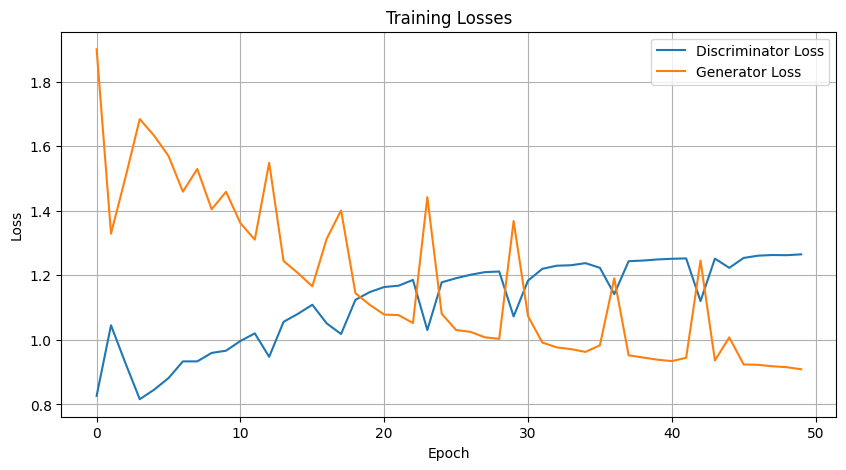

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid()
plt.savefig('./Metrics/DCGAN_generator_discriminator_losses.png')
plt.show()

##SSIM Score

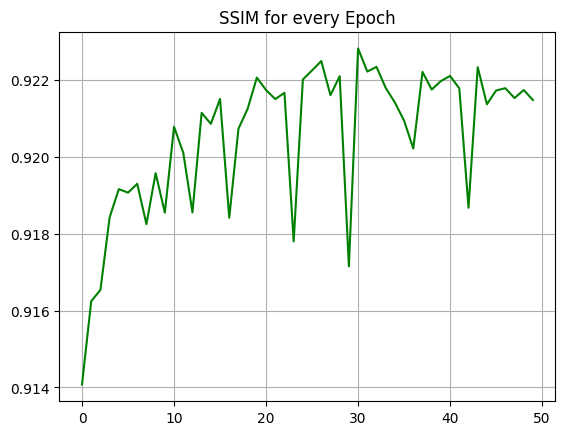

In [17]:
plt.title("SSIM for every Epoch")
plt.plot(SSIM_SCORES_EPOCHS,color="green")
plt.grid()
plt.savefig('./Metrics/DCGAN_SSIM.png')
plt.show()

In [18]:
print(f"Mean SSIM Score: {np.mean(SSIM_SCORES_EPOCHS)}")

Mean SSIM Score: 0.9205374121665955


## KID Score

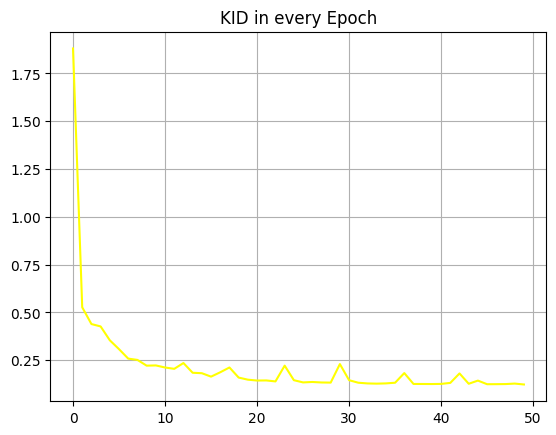

In [19]:
plt.title("KID in every Epoch")
plt.plot(KID_SCORES_EPOCHS,color="yellow")
plt.grid()
plt.savefig('./Metrics/KID_losses.png')
plt.show()

In [20]:
print(f"Mean KID: {np.mean(KID_SCORES_EPOCHS)}")

Mean KID: 0.22079315043640133
